## comparison of DCMEX obs vs model
* take Dec model output -> smaller domain


In [1]:
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
from glob import glob
import seaborn as sns
import xesmf as xe
import pandas as pd

from scipy.special import gamma
from scipy.special import gammainc, gammaincc, gdtr


In [11]:
# make dict of files 
def open_correct_hr_files(hr):
    file_ending = ['.nc', '_density.nc', '_w.nc']
    file_names = ['hydro', 'density', 'updraft'] # number = hydrometeor values // density
    nc_file_loc = '/gws/nopw/j04/dcmex/users/dfinney/data/CASIM/dd455_4apr2024_ncs_27feb2025v2/20220730T0000Z/expt1/'
    files_dict = {}
    for i in range(len(file_ending)):
        file = f'{nc_file_loc}20220730T0000Z_LMagda_km1p5set1_expt1_pz0{hr}{file_ending[i]}'
        files_dict[file_names[i]] = xr.load_dataset(file, decode_timedelta=True)
    return files_dict

## silly output is sometimes on different grids
def re_grid_stuff(file_to_change, file_correct_grid):
    regridder = xe.Regridder(file_to_change, file_correct_grid, "bilinear")
    corrected_file = regridder(file_to_change)
    return corrected_file

## this is applying to grid_lat and grid_lon - which is different from actual lat + lon
def slice_smaller_domain(dataframe, min_lat, max_lat, min_lon, max_lon):
    sliced_df = dataframe.sel(grid_latitude=slice(min_lat, max_lat), grid_longitude=slice(min_lon, max_lon))
    return sliced_df
    

In [12]:
## nc output is every hr, and 15 min interval recorded 
file_dict_16 = open_correct_hr_files('16')
file_dict_17 = open_correct_hr_files('17')

## updraft nc is on slightly different grid, so just needs fixing
file_dict_16['updraft_regrid'] = re_grid_stuff(file_dict_16['updraft'], file_dict_16['hydro'])
file_dict_17['updraft_regrid'] = re_grid_stuff(file_dict_17['updraft'], file_dict_17['hydro'])

### we also want a smaller domain - currently looking at domain over wider New Mexico
## slice limits
min_gridlat = -0.15
max_gridlat = 0.14
min_gridlon = 359.93
max_gridlon = 360.11

# make the domain smaller for each variable
sub_domain_16 = {key : slice_smaller_domain(data, min_gridlat, max_gridlat, min_gridlon, max_gridlon) for key, data in file_dict_16.items()}
sub_domain_17 = {key : slice_smaller_domain(data, min_gridlat, max_gridlat, min_gridlon, max_gridlon) for key, data in file_dict_17.items()}

# need to pull out the orography of the land - which can be used to calculate the true altitude
orog = '/gws/nopw/j04/dcmex/users/dfinney/data/CASIM/dd455_4apr2024_ncs_27feb2025v2/20220716T0000Z_LMagda_km1p5set1_expt1_pa000_model_orog.nc'
orography = xr.load_dataset(orog, decode_timedelta=True) ## orography over 
orography_regrid = re_grid_stuff(orography, file_dict_17['hydro']) # same file applys to all time steps (obviously)
## slice the alt data as well
orog_sub_domain = slice_smaller_domain(orography_regrid, min_gridlat, max_gridlat, min_gridlon, max_gridlon)  

# the level_height is not very informative, we can create real altASL from level_height and sigma (silly model thing - model level vary with altitude)
altASL = sub_domain_17['hydro']['level_height'] + sub_domain_17['hydro']['sigma'] *  orog_sub_domain['surface_altitude']

In [13]:
## now pull out the time steps from the model we want to look at
## the time relates to 'hydro' numbers (most important variable)
# (density / updraft are at another slightly different times, but close enough)
data_1715 = {key: data.isel(time=0) for key, data in sub_domain_17.items()}
data_1645 = {key: data.isel(time=2) for key, data in sub_domain_16.items()}
data_1700 = {key: data.isel(time=3) for key, data in sub_domain_16.items()}


## graupel in the model
Cloud microphysics is parameterised via a bulk scheme called CASIM. I.e. the number and mass of cloud hydrometeors are represented by a given distribution. In CASIM we use a gamma distribution (Field, et al., 2023):

$$\mathcal{N}(D)=n_x\frac{\lambda_{x}^{1+\mu_x}}{\Gamma(1+\mu_x)}D^{\mu_x}e^{-\lambda D}$$

* $D$: particle diameter (m)
* $n_x$: the number concentration for the hydrometeor (graupel in this case) (m-3)
* $\lambda_x$: the slope parameter that evolves as mass and number change (needs calculation)
* $\mu_x$: fixed shape parameter for each type of hydrometeor

In each grid cell $\lambda_x$ evolves in each time step, and needs to be calculated to understand the distribution.

$$\lambda = (a\frac{n_x}{mass}\frac{\Gamma(1+\mu+3)}{\Gamma(1+\mu)})^{\frac{1}{3}}$$

* $a$ is a constant specific to the hydrometeor

In [ ]:
### getting into what we are interested in! - pulling out graupel numbers at each timestep

# pulling out the graupel values from the nc files
def pull_out_graupel(time_dict):
    graupel_n = time_dict['hydro']['number_of_graupel_particles_per_kg_of_air'] # kg-1
    graupel_m = time_dict['hydro']['mass_fraction_of_graupel_in_air'] # kg kg-1

    # not most useful of units, so will convert to m3
    air_density = time_dict['density']['Density used for rad layers (kg m-3)'] # kg m-3 
    ## !!!! basic nc -> number = kg-1 units, use air density (kg m-3) -> kg-1 * kg m-3 = m-3 units
    ## !!!! basic nc -> mass = kg kg-1 units, use air density (kg m-3) -> kg kg-1 * kg m-3 = kg m-3 units

    graupel_m_m3 = graupel_m * air_density
    graupel_n_m3 = graupel_n * air_density

    return {'g_mass' : graupel_m_m3, 'g_number' : graupel_n_m3}

graupel_1715 = pull_out_graupel(data_1715)
graupel_1645 = pull_out_graupel(data_1645)
graupel_1700 = pull_out_graupel(data_1700)



In [15]:
### functions to calculate distribution
## given constants from Field, et al. (2023)
## mu, mass-dimention (a,b)
hydroparameters = {'liquid':[2.5,522,3],
                   'rain':[2.5,522,3],
                   'ice':[2.5,np.pi*200/6,3],
                   'snow':[2,0.026,2],
                   'graupel':[2.5,np.pi*500/6,3]}

## Function for calculating lamda from mass and number
## with prescribed model number + mass (+ specify type of hydrometeor), lambda can be calculated - to work out distribution
def calc_lambda(model_mass, model_num, hydro):
    # Read in gamma PDF values (Field et al., 2023, Table 1)
    mu = hydroparameters[hydro][0]
    c = hydroparameters[hydro][1]
    d = hydroparameters[hydro][2]
    
    gamma_ratio = gamma(1+mu+d) / gamma(1+mu)
    nm_ratio = model_num / model_mass
    if d == 2:
        lam = np.sqrt(c*nm_ratio*gamma_ratio)
    elif d == 3:
        lam = np.cbrt(c*nm_ratio*gamma_ratio)
    else:
        lam = np.nan
    return lam

### Function for model gamma function in (m-3 m-1)
# x = diameter, n = number conc, mu = mu, lambda = lambda (needs calculating)
def model_gamma_pdf(x,n,mu,lamda):
    n0 = (n) * (lamda**(1+mu)) / (gamma(1+mu)) # directly pulled from field paper - (A2)
    N = n0 * (x**mu) * (np.exp(-lamda*x)) 
    return N


### Function for integral over the lower and upper limits of the gamma PDF
def partial_integral_gamma(n,mu,lam,lower,upper):
    lower_inc = gammainc(1+mu,lam*lower)
    upper_inc = gammainc(1+mu,lam*upper)
    return n*(upper_inc-lower_inc)



In [16]:
## apply to our different time steps
hydro='graupel'

# calculate lambda
graupel_1715['lambda'] = calc_lambda(graupel_1715['g_mass'], graupel_1715['g_number'], hydro)
graupel_1645['lambda'] = calc_lambda(graupel_1645['g_mass'], graupel_1645['g_number'], hydro)
graupel_1700['lambda'] = calc_lambda(graupel_1700['g_mass'], graupel_1700['g_number'], hydro)


## graupel in observations
we will be using in-situ images to do our evaluation.

In [2]:
# got extra funtictions
import sys
# actually, pull in functions i have written previously
sys.path.append('/home/users/esree/phd_plots/paper1_figs/')
from shared_functions import pull_files_together, cloud_pass_time, cnn_labelled_df

# again, another useful function
sys.path.append('/home/users/esree/dcmex_instruments/general-non-image/functions/')
from aimms_data import get_nc_variable, mask_data, flatten_20hz_variable

In [3]:
ds_path = '/gws/nopw/j04/dcmex/users/ezriab/processed_stats/v3_conc/' # different paths, as accounted for HPC in v3 - only 2ds
hvps_path = '/gws/nopw/j04/dcmex/users/ezriab/processed_stats/v2_conc/' 
manc_file_loc = '/home/users/esree/dcmex_instruments/co-located-files/manc_ice_files.json' # 2ds + hvps paired for a date (also has faam too - for TAS adjustment)

full_data_dict = pull_files_together(ds_path, hvps_path, manc_file_loc)

day_dict = full_data_dict['220730'] # this is the date we are comparing to
ch0_df, ch1_df, hvps_df = cnn_labelled_df(day_dict)
start_time, end_time = cloud_pass_time(day_dict) # fabulous function made earlier, get pass start / end times


# with the obs, we have 2 simultaneous images of same volume of air for 2D-S instrument - called ch0 and ch1
# we also want to only consider the CP particles -> 'compact particles' - from CNN classification, a proxy for graupel
ch0_cp = ch0_df[ch0_df['habit'] == 'CP']
ch1_cp = ch1_df[ch1_df['habit'] == 'CP']


## there are quite a few cloud passes for the 30th, and we will look at the ones close to the model times we have choosen
specif_passes = zip(start_time[5:9], end_time[5:9]) # only use specif passes


/home/users/esree/phd_plots/paper1_figs/shared_functions.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['second'] = pd.to_datetime(df['second'])
/home/users/esree/phd_plots/paper1_figs/shared_functions.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['second'] = pd.to_datetime(df['second'])
/home/users/esree/phd_plots/paper1_figs/shared_functions.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [4]:
# we also want to get a list of seconds from these passes - so can get other aircraft observations at the same time

## make a dict of passes + build from there
pass_dict = {} 

for start_s, end_s in specif_passes:
    start_str = f'{str(start_s)[11:13]}{str(start_s)[14:16]}'
    start_s = start_s.replace(microsecond=0)
    end_s = end_s.replace(microsecond=0) # just going to remove the microseconds, its fine

    pass_dict[start_str] = {}
    pass_dict[start_str]['sec_list'] = pd.date_range(start=start_s, end=end_s, freq='S') #

# importantly, we are going to filter by the updraft (w wind component)
w_file = day_dict['aircraft_files'][1]
## need a bit of work from going raw nc core-cloud-phy_faam -> usuable w 
unit, longname, raw_var = get_nc_variable(w_file, 'aimms_w', 'aimms', time = True)
_, _, flag_values = get_nc_variable(w_file, 'aimms_flag', 'aimms') # also need masking bad data 
raw_var_masked = mask_data(raw_var, flag_values)
# also need to flatten it out - 20hz
raw_var, var_time = flatten_20hz_variable(raw_var_masked) ## raw_var == usable w!


## so at each second want the total conc of graupel - need to sum up along the size bins in ch0_cp / ch1_cp
for pass_time in pass_dict:
    second_list = pass_dict[pass_time]['sec_list']

    pass_list = []
    for second in second_list:
        correspond_w = raw_var.sel(time = second).item()

        # get the calculated conc too
        ch0_second_df = ch0_cp[ch0_cp['second'] == second]
        ch1_second_df = ch1_cp[ch1_cp['second'] == second]

        ch0_conc = ch0_second_df['conc'].sum()
        ch1_conc = ch1_second_df['conc'].sum()

        pass_list.append({'second': second, 'w': correspond_w, 'ch0_conc': ch0_conc, 'ch1_conc': ch1_conc})
    pass_df = pd.DataFrame(pass_list)
    pass_dict[pass_time]['df'] = pass_df

/tmp/ipykernel_2333211/225143534.py:12: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  pass_dict[start_str]['sec_list'] = pd.date_range(start=start_s, end=end_s, freq='S') #


In [5]:
## to get the observations to match resolution of model data, we will average values over a 10 second period
# some logic is needed to get 10s intervals - will need to drop a couple sec either end if not
for pass_time in pass_dict:
    df = pass_dict[pass_time]['df']
    total_sec = len(df)

    whole_10 = total_sec % 10
    if whole_10 == 0:
        factor_of_10 = total_sec
    else:
        even_remainder = whole_10 % 2

        if even_remainder == 0:
            start_deduct = whole_10/2
            end_deduct = whole_10/2
            factor_of_10 = total_sec - whole_10

        else:
            even_deduct = whole_10 - even_remainder
            start_deduct = even_deduct / 2
            end_deduct = even_deduct / 2 + even_remainder # just deduct extra 
            factor_of_10 = total_sec - even_deduct - even_remainder
        # now we just ignore a couple rows, to make nice averages over 10
        df = df[int(start_deduct) : -int(end_deduct)]

    avg_10s_row = []
    final_len = factor_of_10 - 9
    for i in range(0, final_len, 10):
        avg_df = df[i:i+10]
        first_sec = avg_df['second'].iloc[0] # just use this 
        avg_10s_row.append({'second': first_sec, 
                            'mean_w': avg_df['w'].mean(),
                            'ch0_mean_conc': avg_df['ch0_conc'].mean(),
                            'ch1_mean_conc': avg_df['ch1_conc'].mean()})
    
    mean_10s_df = pd.DataFrame(avg_10s_row)
    pass_dict[pass_time]['10s_mean'] = mean_10s_df


## getting to comparison

For the best comparison, we need to compare like for like as much as possible. <br>
So, filtering the model to be above a certain altitude, and both to to be in a specific updraft speed.

In [ ]:
# alt mask
mask_asl = altASL  > 6000 # we hide everything below 6000m

# applying mask to model data - just make into new dict
alt_graupel_1715 = {key: data.where(mask_asl) for key, data in graupel_1715.items()}
alt_graupel_1645 = {key: data.where(mask_asl) for key, data in graupel_1645.items()}
alt_graupel_1700 = {key: data.where(mask_asl) for key, data in graupel_1700.items()}

##### updraft masking ######
# want to choose minimum updraft speed 
updraft_threshold = 1 # e.g. >1 m/s

## applying to model
graupel_list = [alt_graupel_1715, alt_graupel_1645, alt_graupel_1700] # ['g_mass', 'g_number', 'lambda']
data_list = [data_1715, data_1645, data_1700] # ['hydro', 'density', 'updraft', 'updraft_regrid']

def w_model_mask(graupel_dict, data_dict, threshold):
    w_mask = data_dict['updraft_regrid'] > threshold # again, will just hide everything that doesn't apply
    new_dict = {key: data.where(w_mask) for key, data in graupel_dict.items()}
    return new_dict

filt_graupel_1715 = w_model_mask(alt_graupel_1715, data_1715, updraft_threshold)
filt_graupel_1645 = w_model_mask(alt_graupel_1645, data_1645, updraft_threshold)
filt_graupel_1700 = w_model_mask(alt_graupel_1700, data_1700, updraft_threshold)


## applying to observations    
for key in pass_dict:
    pass_sub_dict = pass_dict[key]
    avg_10s = pass_sub_dict['10s_mean']
    # apply threshold - remove seconds where threshold not met
    w_thresh = avg_10s[(avg_10s['mean_w'] > updraft_threshold)]
    # and also change 0 -> nan 
    columns_to_mask = ['ch0_mean_conc', 'ch1_mean_conc']
    w_thresh[columns_to_mask] = w_thresh[columns_to_mask].replace(0, np.nan)
    pass_dict[key]['masked_10s'] = w_thresh
    

/tmp/ipykernel_2333211/4082706595.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  w_thresh[columns_to_mask] = w_thresh[columns_to_mask].replace(0, np.nan)
/tmp/ipykernel_2333211/4082706595.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  w_thresh[columns_to_mask] = w_thresh[columns_to_mask].replace(0, np.nan)
/tmp/ipykernel_2333211/4082706595.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

## finally get to comparison 
we need to calculate part of the size distribution that the observations saw

In [53]:
hydro='graupel'
mu = hydroparameters[hydro][0]
# size limits
min_2ds_size = 300e-6 # in m - but = 300 micron
max_2ds_size = 1280e-6 # 1280 micron

graupel_1645['g_conc'] = partial_integral_gamma(graupel_1645['g_number'], mu, graupel_1645['lambda'], min_2ds_size, max_2ds_size)/1e6 # /1e6 = get m-3 -> cm-3
graupel_1715['g_conc'] = partial_integral_gamma(graupel_1715['g_number'], mu, graupel_1715['lambda'], min_2ds_size, max_2ds_size)/1e6 
graupel_1700['g_conc'] = partial_integral_gamma(graupel_1700['g_number'], mu, graupel_1700['lambda'], min_2ds_size, max_2ds_size)/1e6 

## also going to hide 0 values of conc 
graupel_1645['g_conc'] = graupel_1645['g_conc'].where(graupel_1645['g_conc'] != 0)
graupel_1715['g_conc'] = graupel_1715['g_conc'].where(graupel_1715['g_conc'] != 0)
graupel_1700['g_conc'] = graupel_1700['g_conc'].where(graupel_1700['g_conc'] != 0)

# just going to remove the dims - not helpful when plotting a histogram
graupel_1645['flat_conc'] = graupel_1645['g_conc'].stack(all_dims=("model_level_number", "grid_latitude", "grid_longitude"))
graupel_1715['flat_conc'] = graupel_1715['g_conc'].stack(all_dims=("model_level_number", "grid_latitude", "grid_longitude"))
graupel_1700['flat_conc'] = graupel_1700['g_conc'].stack(all_dims=("model_level_number", "grid_latitude", "grid_longitude"))


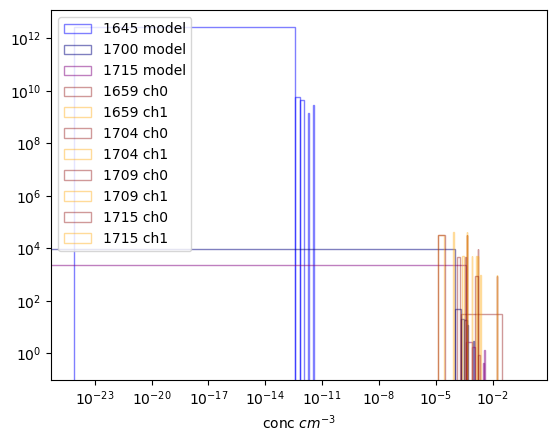

In [72]:
# lets make a histogram of concentrations
# model
plt.hist(graupel_1645['flat_conc'], bins=10, edgecolor= 'blue', facecolor = 'none', alpha=0.5, label = '1645 model', density = True)#, stacked = True) #, normed=True)   # normalized
plt.hist(graupel_1700['flat_conc'], bins=10, edgecolor= 'navy', facecolor = 'none', alpha=0.5, label = '1700 model', density = True)#, stacked = True) #, normed=True)   # normalized
plt.hist(graupel_1715['flat_conc'], bins=10, edgecolor= 'purple', facecolor = 'none', alpha=0.5, label = '1715 model', density = True)#, stacked = True) #, normed=True)   # normalized

# obs
'''
plt.hist(pass_dict['1659']['masked_10s']['ch0_mean_conc'], bins=30, edgecolor= 'red', facecolor = 'none', alpha=0.5, label = '1659 ch0', density = True)#, stacked = True) #, normed=True)   # normalized 
plt.hist(pass_dict['1659']['masked_10s']['ch1_mean_conc'], bins=30, edgecolor= 'red', facecolor = 'none', alpha=0.5, label = '1659 ch1', density = True)#, stacked = True) #, normed=True)   # normalized 

plt.hist(pass_dict['1704']['masked_10s']['ch0_mean_conc'], bins=30, edgecolor= 'red', facecolor = 'none', alpha=0.5, label = '1704 ch0', density = True)#, stacked = True) #, normed=True)   # normalized 
plt.hist(pass_dict['1704']['masked_10s']['ch1_mean_conc'], bins=30, edgecolor= 'red', facecolor = 'none', alpha=0.5, label = '1704 ch1', density = True)#, stacked = True) #, normed=True)   # normalized 

plt.hist(pass_dict['1709']['masked_10s']['ch0_mean_conc'], bins=30, edgecolor= 'red', facecolor = 'none', alpha=0.5, label = '1709 ch0', density = True)#, stacked = True) #, normed=True)   # normalized 
plt.hist(pass_dict['1709']['masked_10s']['ch1_mean_conc'], bins=30, edgecolor= 'red', facecolor = 'none', alpha=0.5, label = '1709 ch1', density = True)#, stacked = True) #, normed=True)   # normalized 

plt.hist(pass_dict['1715']['masked_10s']['ch0_mean_conc'], bins=30, edgecolor= 'red', facecolor = 'none', alpha=0.5, label = '1715 ch0', density = True)#, stacked = True) #, normed=True)   # normalized 
plt.hist(pass_dict['1715']['masked_10s']['ch1_mean_conc'], bins=30, edgecolor= 'red', facecolor = 'none', alpha=0.5, label = '1715 ch1', density = True)#, stacked = True) #, normed=True)   # normalized 
'''
ch0_color = 'darkred'
ch1_color = 'orange'
for t in ['1659', '1704', '1709', '1715']:
    plt.hist(pass_dict[t]['masked_10s']['ch0_mean_conc'], bins=30,
             edgecolor=ch0_color, facecolor='none', alpha=0.4,
             label=f'{t} ch0', density=True)

    plt.hist(pass_dict[t]['masked_10s']['ch1_mean_conc'], bins=30,
             edgecolor=ch1_color, facecolor='none', alpha=0.4,
             label=f'{t} ch1', density=True)


plt.legend()
plt.xlabel('conc $cm^{-3}$')
plt.xscale('log')
plt.yscale('log')
